<img src="../img/ods_stickers.jpg" />

## 时间序列处理与应用

---

#### 介绍

一般情况下，在进行数据分析时，几乎都会遇到与时间序列相关的任务。例如：某企业的某项指标在第二天或者每周，又或每月等会发生什么；某款应用每天的下载量是多少等等。在本节实验中，将使用不同的方法来处理这些与时间序列相关的任务。

在本节中，还会介绍如何使用 Python 中的时间序列处理工具，可以使用哪些方法和模型进行预测，什么是双指数和三指数拟合，如果遇到非平稳的数据该怎么办，如何建立 SARIMA 模型，如何使用 XGBoost 进行预测等。此外，本次实验也会将这些算法应用在来自实际采集的数据中。

#### 知识点

- 时间序列
- SARIMA
- 线性回归
- XGBoost
- Prophet

---

### 时间序列数据介绍

让我们先从时间序列的简单 [<i class="fa fa-external-link-square" aria-hidden="true"> 定义</i>](https://en.wikipedia.org/wiki/Time_series) 开始。一般情况下，时间序列可以定义如下：

>时间序列指的是同一个统计指标的数值按其发生的时间先后顺序排列而构成的一组数列。

因此，时间序列数据通常是与时间相关的序列数据，并且与随机样本数据相比，时间序列可能会包含了一些有用的历史信息。

在本次实验中，主要使用 Statsmodels 这个库来对序列进行处理，该库拥有许多的统计函数，也包括处理时间序列的函数。对于从 R 语言转到 Python 的人来说，Statsmodels 肯定会更加熟悉，因为它支持 `Wage~Egex + Education` 等模型定义。先导入一些实验所需要的库。

In [1]:
import warnings
from itertools import product
from dateutil.relativedelta import relativedelta
from tqdm import tqdm_notebook
from scipy import stats
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf  # 统计与计量
from scipy.optimize import minimize  # 优化函数
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
warnings.filterwarnings('ignore')

为了直观地理解时间序列。通过举个例子来进行说明，这里有一份真实的手机游戏数据，记录的是用户每小时观看的广告和每天游戏货币的支出，先导入数据集。

In [2]:
ads = pd.read_csv('../../data/ads.csv',
                  index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('../../data/currency.csv',
                       index_col=['Time'], parse_dates=['Time'])
ads.shape, currency.shape

((216, 1), (300, 1))

为了便于观察，画出广告数据的图形。

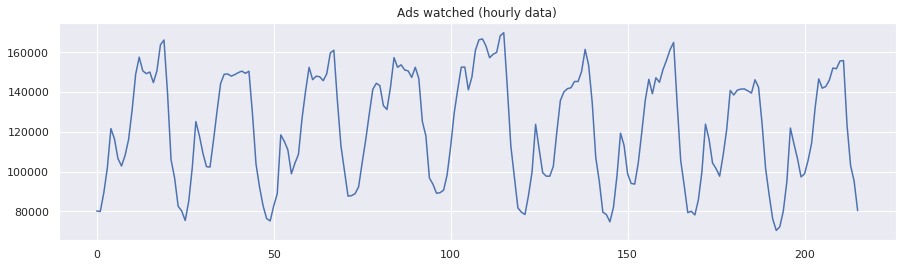

In [3]:
plt.figure(figsize=(15, 4))
plt.plot(ads.Ads.values)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

同样的方法，画出游戏币支出的图形。

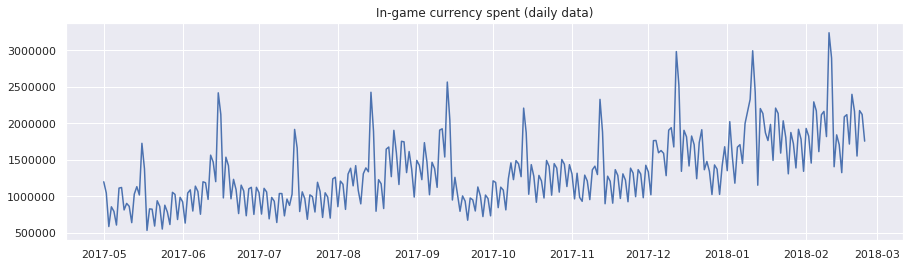

In [4]:
plt.figure(figsize=(15, 4))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### 预测质量评价指标

在开始预测之前，先来理解怎么样去评估模型预测结果的好坏。常用的评价指标如下：

[<i class="fa fa-external-link-square" aria-hidden="true"> R 平方](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): 可决系数，取值范围为 $[0, +\infty)$ ，其值越大，表示拟合效果越好 调用接口为 `sklearn.metrics.r2_score`，计算公式如下：

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

[<i class="fa fa-external-link-square" aria-hidden="true"> 平均绝对误差</i>](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): 即所有单个观测值与算术平均值的偏差的绝对值的平均。这是一个可解释的指标，因为它与初始系列具有相同的计量单位。取值范围为 $[0, +\infty)$ ，调用接口为 `sklearn.metrics.mean_absolute_error` ，计算公式如下：

$$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$$

[<i class="fa fa-external-link-square" aria-hidden="true"> 中值绝对误差</i>](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): 与平均绝对误差类似，即所有单个观测值与算术平均值的偏差的绝对值的中值。而且它对异常值是不敏感。取值范围为 $[0, +\infty)$ ，调用接口为 `sklearn.metrics.median_absolute_error` ,计算公式如下：

$$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$$

[<i class="fa fa-external-link-square" aria-hidden="true"> 均方差</i>](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)：最常用的度量标准，对大偏差给予较高的惩罚，反之亦然，取值范围为 $[0, +\infty)$ ，调用接口为 `sklearn.metrics.mean_squared_error` ,计算公式如下：

$$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$$

[<i class="fa fa-external-link-square" aria-hidden="true"> 均方对数误差</i>](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): 这个与均方差类似，通过对均方差取对数而得到。因此，该评价指标也更重视小偏差。这指标通常用在呈指数趋势的数据。取值范围为 $[0, +\infty)$ ，调用接口为 `sklearn.metrics.mean_squared_log_error` ,计算公式如下：

$$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$$

平均绝对百分比误差：这与 MAE 相同，但是是以百分比计算的。取值范围为 $[0, +\infty)$ ，计算公式如下：

$$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$$ 

平均绝对百分比误差的实现如下：

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

导入上述的评价指标

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

现在我们知道了如何评价模型预测的质量，那在实际应用中该如何选择呢？先来构建模型。

#### 平移、平滑、评估

一般情况下，处理时间序列的核心任务就是根据历史数据来对未来进行预测。这可以通过许多模型来完成。先来介绍一个最老也是最简单的模型：移动平均。

在移动平均中，假设 $\hat{y}_{t}$ 仅仅依赖 $k$ 个最相近的值，对这 $k$ 个值求平均值得到 $\hat{y}_{t}$ 。公式如下式所示：

$$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$$

定义一个函数来实现移动平均。

In [7]:
def moving_average(series, n):
    """通过移动平均，计算最新的值
    """
    return np.average(series[-n:])


moving_average(ads, 24)  # 预测最新的观察值

116805.0

很明显，这种方法不能预测未来很久的数据。因为，为了预测下一个的值，就需要实际观察到之前的值。但这种方法可以对原始数据进行平滑。在进行平滑时，窗口越宽，也就是 k 的值越大，趋势越平滑。对于波动非常大的数据，这种处理可以使其更易于分析。

Pandas 提供了一个移动平滑的接口 `DataFrame.rolling(window).mean()`。为了方便，这里直接使用该接口来进行实验。先来定义一个能够画出移动平滑结果的函数。

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
    series - 时间序列
    window - 滑动窗口尺寸 
    plot_intervals -置信区间
    plot_anomalies - 显示异常值 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 4))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # 画出置信区间
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # 画出奇异值
        if plot_anomalies:
            anomalies = pd.DataFrame(
                index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

先来看平滑窗口为四个小时怎么样：

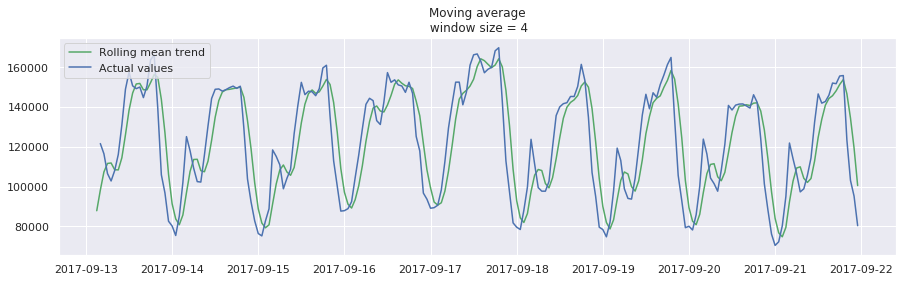

In [9]:
plotMovingAverage(ads, 4)

现在尝试平滑窗口为 12 个小时：

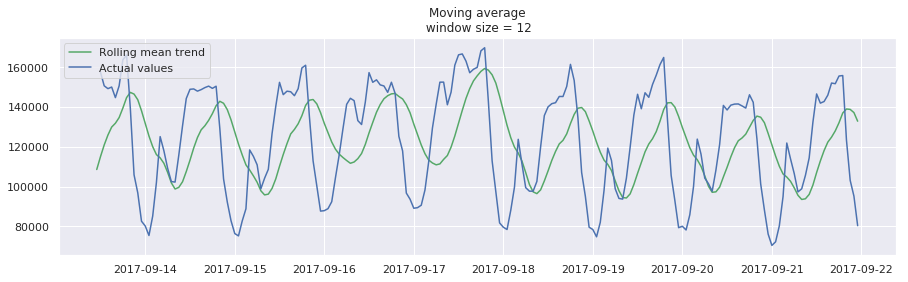

In [10]:
plotMovingAverage(ads, 12)

现在平滑窗口取为 24 个小时，得到的是每天的趋势。

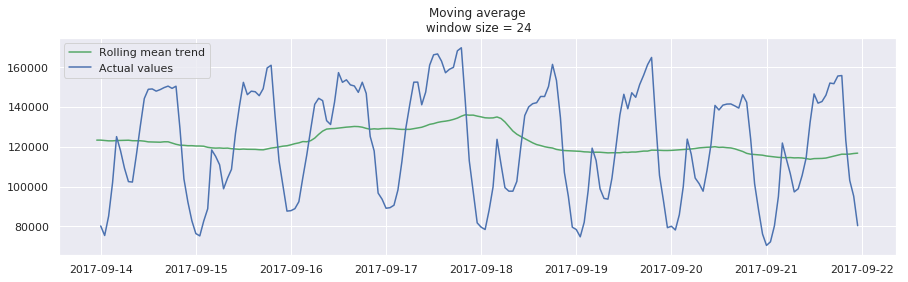

In [11]:
plotMovingAverage(ads, 24)

当对时间数据进行平滑时，可以清楚的看到整个用户查看广告的动态过程。在整个周末期间（2017-09-16），整个值变得很高，这是因为周末许多人都会有更多的时间。

绘制平滑值的置信区间。

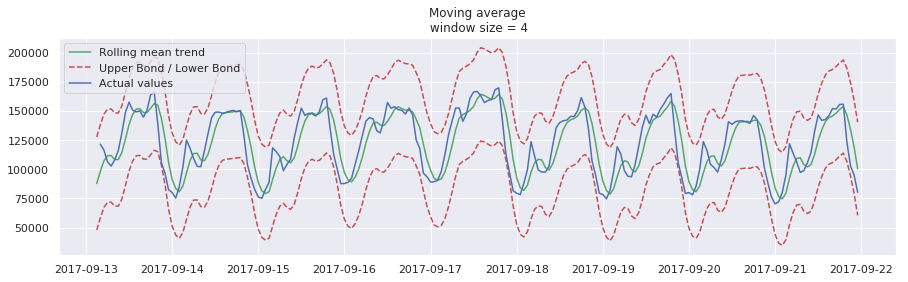

In [12]:
plotMovingAverage(ads, 4, plot_intervals=True)

现在通过平滑来做一个异常值检测系统。先给原始数据中添加一个异常值。

In [13]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2  # 设置异常

为了能够显示异常值点，将前面定义的 `plotMovingAverage` 函数中的 `plot_anomalies` 设置为 `True` 即可。看看是否检测到异常值点。

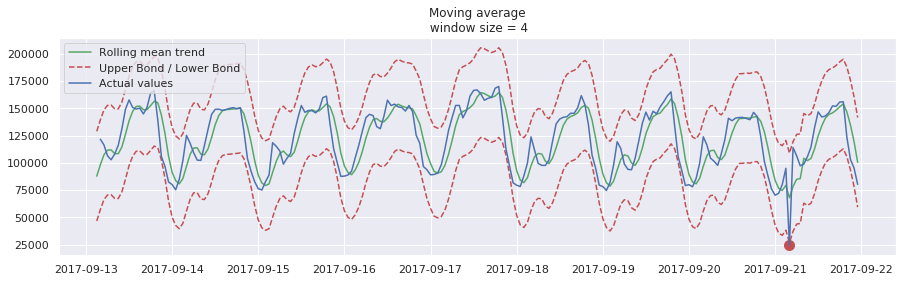

In [14]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

从上图中可以看到，已成功检测到异常。第二份数据是否也一样呢？

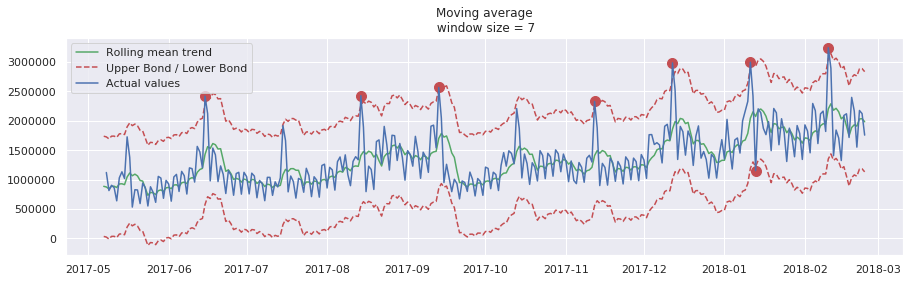

In [15]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)  # 周平滑

在这里的检测结果出乎意料，从图中可以看到该方法的缺点：它没有捕获数据中的每月季节性，并将几乎所有的峰值标记为异常。

加权平滑也是一种处理时间序列的平滑技术。加权平滑是对移动平均进行的一个修改，将 $k$ 个之前的数据进行加权求和，即：

$$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$$

先来定义加权平滑的函数。

In [16]:
def weighted_average(series, weights):
    """计算加权平均序列
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

使用加权平滑函数测试一下广告数据。

In [17]:
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

### 指数平滑

与加权平滑不同，加权平滑只是加权时间序列最后的 k 个值，而 [<i class="fa fa-external-link-square" aria-hidden="true"> 指数平滑</i>](https://en.wikipedia.org/wiki/Exponential_smoothing) 则是一开始加权所有可用的观测值，而当每一步向后移动窗口时，进行指数地减小权重，这个过程可以使用下面的公式进行表达。

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

这里，预测值是当前真实值和先前预测值之间的加权平均值。$\alpha$ 权重称为平滑因子。它定义了预测将「忘记」最后一次可用的真实观测值的速度。$\alpha$ 越小，先前观测值的影响越大，系列越平滑。

在函数的递归中隐藏了指数：也就是每次乘以$（1-\alpha）$，其已经包含先前预测值进行$（1-\alpha）$的运算结果。

定义指数平滑的函数：

In [18]:
def exponential_smoothing(series, alpha):
    """
    series - 时间序列
    alpha - 平滑因子
    """
    result = [series[0]]  # 第一个值是一样的
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

定义画出指数平滑结果的函数：

In [19]:
def plotExponentialSmoothing(series, alphas):
    """
    画出不同 alpha 值得平滑结果
    series - 时间序列
    alphas - 平滑因子
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 4))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha),
                     label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

画出广告数据的指数平滑结果：

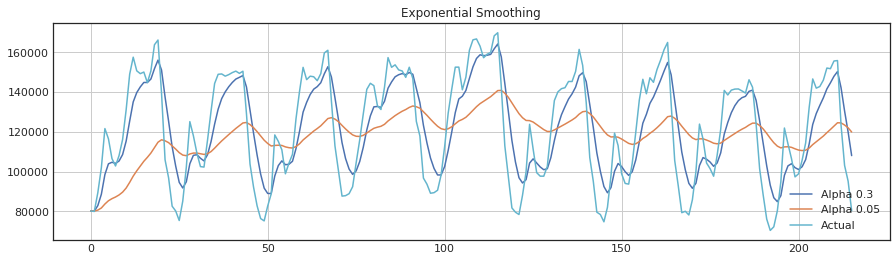

In [20]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

画出游戏币支出数据的指数平滑结果：

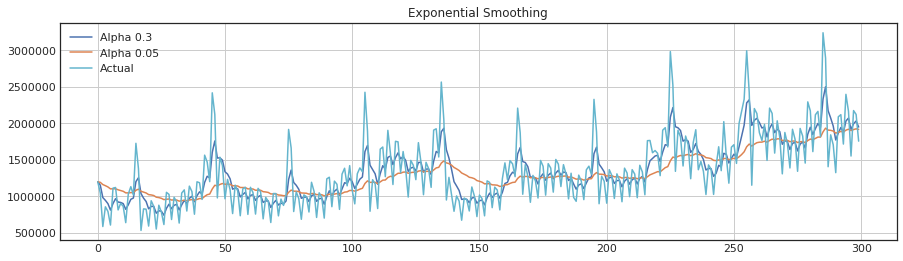

In [21]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

由上图可知，平滑因子越小，平滑结果也就越平滑。

### 双指数平滑

到目前为止，讨论过的方法都是针对单个未来点的预测。虽然有一些很好的平滑，但对于一些复杂数据来说，这还不够。为了能够预测更多未来的点，对指数平滑进行扩展。

为了提取更多细节信息，将时间序列数据分解为两个分量：截距（即水平）$\ell$ 和斜率（即趋势）$b$ 。对于截距，可以使用之前所述的平滑方法进行平滑，对于趋势，则假设时间序列的趋势(未来方向变化)取决于先前值的加权变化，对趋势应用相同的指数平滑。因此，可以使用以下函数来表示：

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

在上面的式子中，第一个函数是截距计算公式，其中的第一项取决于序列的当前值；第二项现在分为以前的水平和趋势值。第二个函数描述趋势，它取决于当前时间点的水平变化和趋势和先前值。在这种情况下，$\beta $ 系数是指数平滑的权重。最终预测是截距和趋势的总和。

定义双指数平滑函数。

In [22]:
def double_exponential_smoothing(series, alpha, beta):
    """
    series - 序列数据
    alpha - 取值范围为 [0.0, 1.0], 水平平滑参数
    beta - 取值范围为 [0.0, 1.0], 趋势平滑参数
    """
    # 原始序列和平滑序列的第一个值相等
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # 预测
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

定义画出双指数平滑结果的函数。

In [23]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
    画出不同参数的实验结果
    series - 序列数据
    alpha - 取值范围为 [0.0, 1.0], 水平平滑参数
    beta - 取值范围为 [0.0, 1.0], 趋势平滑参数
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 4))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta),
                         label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

画出不同 $\alpha$ 和 不同 $\beta$ 的平滑结果

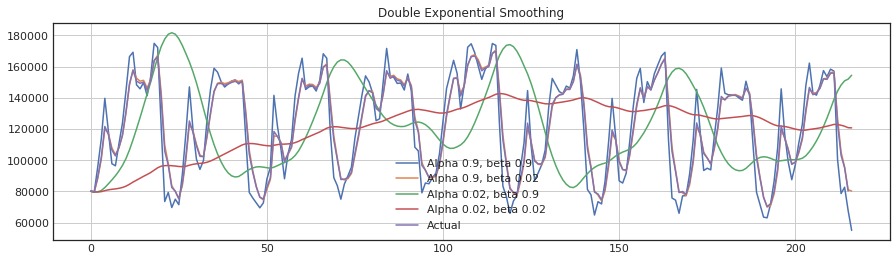

In [24]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

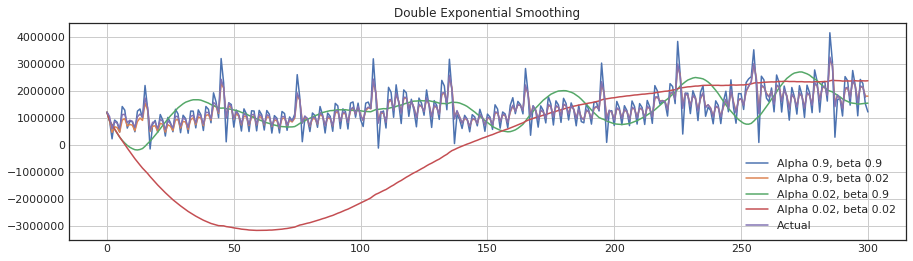

In [25]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[
                               0.9, 0.02], betas=[0.9, 0.02])

从上面的图可以看出，可以通过调整两个参数 $\alpha$ 和 $\beta$ 来得到不同的结果。$\alpha$ 负责序列的平滑，$\beta$ 负责趋势的平滑。值越大，最近观测点的权重越大，模型系列的平滑程度越小。某些参数组合可能会产生奇怪的结果，尤其是手动设置时。我们将研究一下自动选择参数。不过在此之前，让先讨论三指数平滑。

### 三指数平滑

前文研究了指数平滑和双指数平滑。现在开始讲解三指数平滑。

你可能已经猜到了，这个想法是增加第三个组成部分：季节性成分。这意味着如果时间序列预计没有季节性，就不应该使用这种方法。模型中的季节性成分将解释围绕截距和趋势的重复变化，并且将通过季节的长度来指定，换言之，通过变化重复的时段来指定。对于季节中的每个观测值，都有一个单独的组成部分，例如，如果季节的长度为 7 天（每周季节性），则有 7 个季节性成分，也即是一周中的每一天。

三指数平滑可使用下面公式描述：

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

截距现在取决于序列的当前值减去相应的季节性成分。而趋势保持不变，季节性分量取决于系列的当前值减去截距和其先前值。考虑到所有可用季节的成分都是平滑的，例如，如果我们有星期一季节性成分，那么它只会与其他星期一平均。

你可以阅读更多关于 [<i class="fa fa-external-link-square" aria-hidden="true"> 平滑</i>](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm) 如何工作以及如何完成趋势和季节性成分的初始近似。有了季节性因素，模型不仅可以预测未来的一两步，而且还可以预测未来任意的 $ m $ 步，这非常令人期待。

三次指数平滑模型也称为 Holt-Winters 模型，得名于发明人的姓氏 Charles Holt 和他的学生 Peter Winters。此外，模型中还引入了 Brutlag 方法，用来创建置信区间，其公式描述如下：

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$


$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$$

其中 $T$ 是季节的长度，$d$ 是预测的偏差。其他参数取自三指数平滑。想要了解更多细节的内容，可以参考 [<i class="fa fa-external-link-square" aria-hidden="true"> 这篇论文</i>](http://fedcsis.org/proceedings/2012/pliks/118.pdf)。

实现三指数平滑，由于三指数平滑相对复杂，所以这里使用类来进行实现。

In [26]:
# 该代码块较长，直接执行即可
class HoltWinters:

    """
    三次指数模型及其异常值检测

    # series - 时间序列
    # slen - 季节长度
    # alpha, beta, gamma - 三指数模型系数
    # n_preds -预测
    # scaling_factor -置信值设置
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # 计算季节平均值
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # 计算初始值
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen *
                                                    j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0:  # 季节性成分初始化
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series):  # 预测
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) +
                                   seasonals[i % self.slen])

                # 在预测时，增加一些不确定性
                self.PredictedDeviation.append(
                    self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * \
                    (val-seasonals[i % self.slen]) + \
                    (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i % self.slen] = self.gamma * \
                    (val-smooth) + (1-self.gamma)*seasonals[i % self.slen]
                self.result.append(smooth+trend+seasonals[i % self.slen])

                # 偏差按Brutlag算法计算
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### 时间序列交叉验证

在开始构建模型之前，先讨论一下，怎么自动的去选择模型的参数。

 与之前的一样，要评估模型，必须选择适合该任务的损失函数，因为损失函数决定了模型拟合数据的接近程度。然后，使用交叉验证，将损失函数值最终降至全局最小值。

你可能会问，如何对时间序列进行交叉验证？因为时间序列具有时间结构，要保留时间结构，不能随意对数据进行组合。要是随机组合，观测点之间的所有时间依赖关系将丢失。因此，这里需要使用技巧性更强的方法来优化模型参数。

时间序列交叉验证很简单，我们在时间序列的一小部分上训练模型，从开始到时间节点 $t$ ，对下一个 $t+n$ 时刻进行预测，并计算误差。然后，将训练样本扩展到 $t+n$ 值，从 $t+n$ 做出预测，直到 $t+2*n$ ，并继续移动时间序列的测试段，直到达到最后一次可用的观察。因此，在初始训练样本和最后一次观察之间，可以得到与 $n$ 一样多的数据份数。具体过程如下图所示。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033552596">

现在，知道了如何建立交叉验证，就可以通过交叉验证来找到三指数模型的最优参数。回想一下，在广告数据中有每日的季节性，也就是 slen=24 。

实现时间序列的交叉验证。


In [27]:
from sklearn.model_selection import TimeSeriesSplit  # 导入时间序列切分模块


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
    返回交叉验证误差 
    params - 优化参数
    series - 时间序列
    slen - 季节性长度
    """
    # 误差
    errors = []
    values = series.values
    alpha, beta, gamma = params
    # 设置几次交叉
    tscv = TimeSeriesSplit(n_splits=3)
    # 训练
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

和指数平滑的其他模型一样，在三指数模型中，平滑参数的取值范围为 0 到 1 之间。因此，为了最小化损失函数，使用截断牛顿共轭梯度优化算法来进行优化。

In [28]:
data = ads.Ads[:-20]  # 留下一些数据用于测试

# 初始化模型的参数
x = [0, 0, 0]

# 最小化损失函数
opt = minimize(timeseriesCVscore, x0=x,
               args=(data, mean_squared_log_error),
               method="TNC", bounds=((0, 1), (0, 1), (0, 1))
               )

# 取出最优的参数
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# 使用最优参数训练模型
model = HoltWinters(data, slen=24,
                    alpha=alpha_final,
                    beta=beta_final,
                    gamma=gamma_final,
                    n_preds=50, scaling_factor=3)
model.triple_exponential_smoothing()

0.11681811415263998 0.002674202051183794 0.059665015439133884


定义画出三指数平滑图形的函数：

In [29]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
    series - 时间序列
    plot_intervals - 显示置信区间
    plot_anomalies - 显示异常值
    """
    plt.figure(figsize=(15, 4))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(
        series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values < model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond,
                         y2=model.LowerBond, alpha=0.2, color="grey")

    plt.vlines(len(series), ymin=min(model.LowerBond),
               ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result),
                alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

画出广告数据的三指数平滑结果：

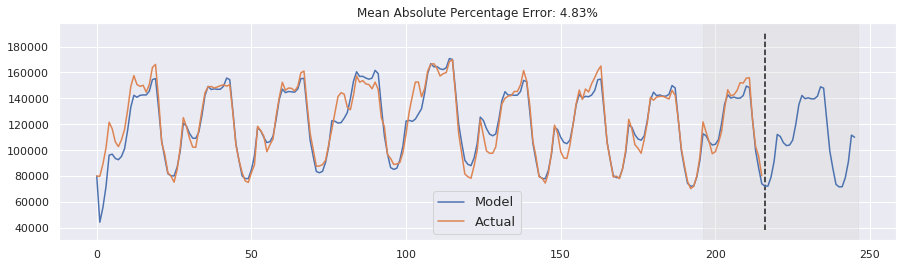

In [30]:
plotHoltWinters(ads.Ads)

画出广告数据的三指数平滑结果，并画出置信区间和异常点：

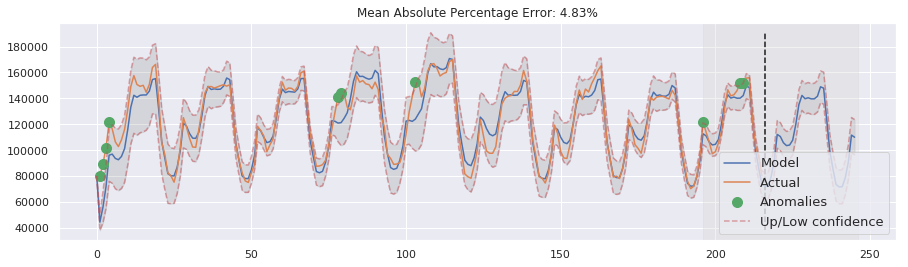

In [31]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

从图中可以看出，模型能够成功地拟合原始的时间序列，并捕捉到了每日季节性和整体向下趋势，甚至一些异常也检测到了。如果你看模型的偏差，你可以清楚地看到模型对序列结构的变化作出了相当大的反应，但随后迅速将偏差返回到正常值，基本上是「遗忘」掉过去。该模型的这一特性使我们能够快速构建异常检测系统，即使对于嘈杂的系列数据，也不需要花费太多时间和精力来准备数据和训练模型。

画出广告数据的三指数平滑的偏差：

Text(0.5, 1.0, "Brutlag's predicted deviation")

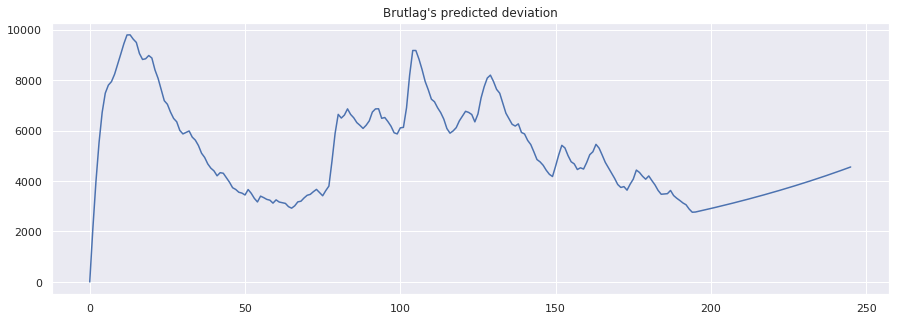

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

对第二个序列数据应用相同的算法，你可能还记得，它具有趋势和 30 天的季节性。

In [33]:
data = currency.GEMS_GEMS_SPENT[:-50]
slen = 30  # 30天的季节性

x = [0, 0, 0]
opt = minimize(timeseriesCVscore, x0=x,
               args=(data, mean_absolute_percentage_error, slen),
               method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen=slen,
                    alpha=alpha_final,
                    beta=beta_final,
                    gamma=gamma_final,
                    n_preds=100, scaling_factor=3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777


画出游戏币支出的三指数平滑结果：

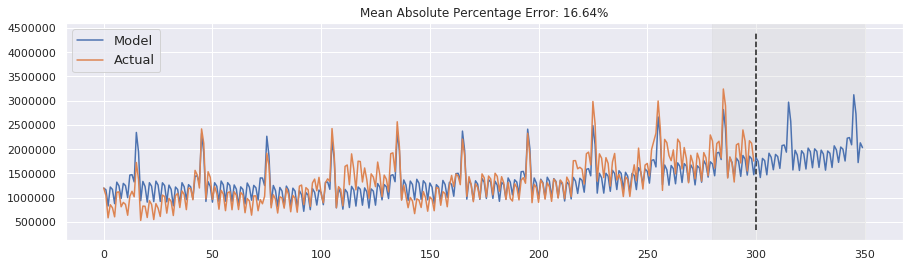

In [34]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

看起来不错，该模型同时捕捉到了上升趋势和季节高峰，与原始数据非常吻合。

画出游戏币支出的三指数平滑结果，并画出置信区间以及异常点。

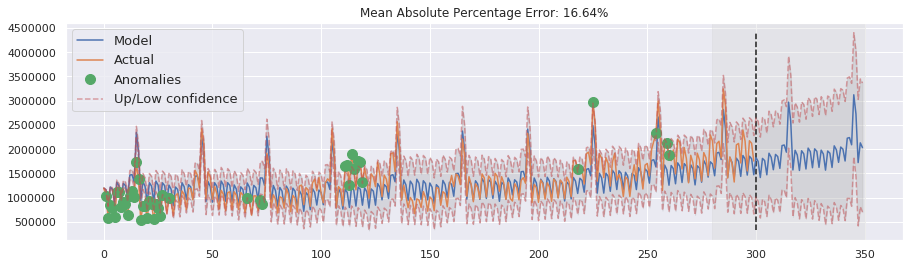

In [35]:
plotHoltWinters(currency.GEMS_GEMS_SPENT,
                plot_intervals=True, plot_anomalies=True)

从上图可以看到，模型也捕获了一些异常。

画出游戏币支出的三指数平滑结果的偏差：

Text(0.5, 1.0, "Brutlag's predicted deviation")

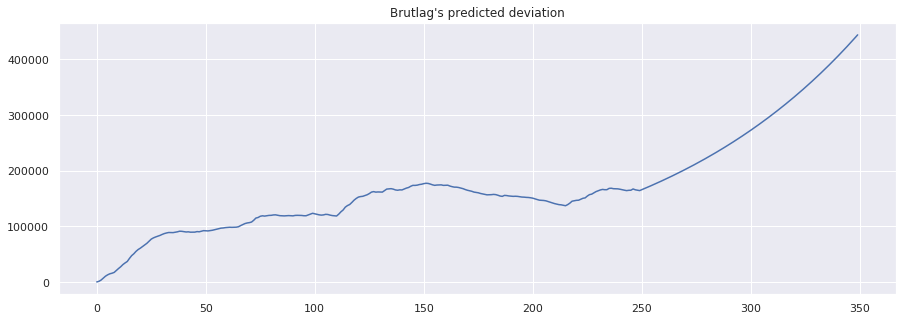

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation")

从图中可以看到，模型的预测偏差随着预测长度的增加而上升。

#### 平稳性

[<i class="fa fa-external-link-square" aria-hidden="true"> 平稳性</i>](https://en.wikipedia.org/wiki/Stationary_process) 通常指的是时间序列是否平稳。

具体来说，如果一个过程是平稳的，这意味着它不会随着时间的推移而改变其统计特性，这里的统计特性指的是均值、方差以及协方差。协方差函数不依赖于时间，它应该只取决于观测值之间的距离。我们可以从 [<i class="fa fa-external-link-square" aria-hidden="true"> Sean Abu</i>](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) 发布的图片上直观地看到这一点。

- 下面红色的图中的时间序列是不稳定的，因为其值会随着时间的增加而增加。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033590996">

- 下面的右图中，方差随时间的变化而变化。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033587970">

- 最后，第 $i$ 项和 $(i + m)$ 项的协方差不应该是时间的函数。在下面的图中，我们可以看到，协方差不是随着时间而恒定的。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033583749">

为什么平稳性如此重要？因为对平稳序列进行预测很容易，因为可以假设未来的统计特性与目前观测到的统计特性是一致的，这使得大多数时间序列模型都以这样或那样的方式去预测这些属性(例如均值或方差)。如果原始序列不是平稳的，未来的预测将是错误的。很不幸，通常在教科书之外看到的大多数时间序列都是非平稳的。

所以，为了理解非平稳性问题，这里举一个例子来进行说明。实验数据为一个高斯白噪声信号。

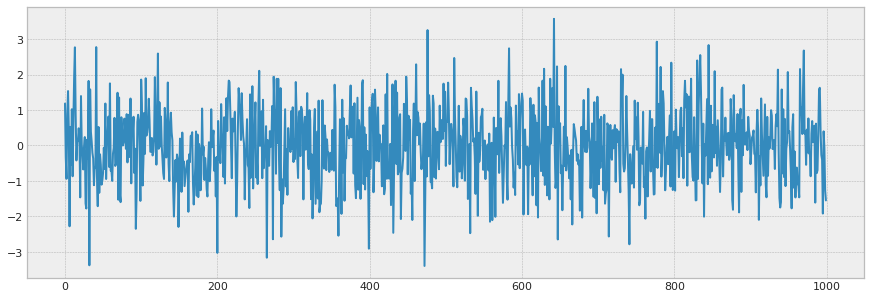

In [37]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

标准正态分布产生的过程是平稳的，在 0 附近振荡，方差为 1 。现在，基于这个过程，生成一个新的时间序列，且与上一个的关系为:

 $$x_t = \rho x_{t-1} + e_t$$

画出高斯白噪声的图形：

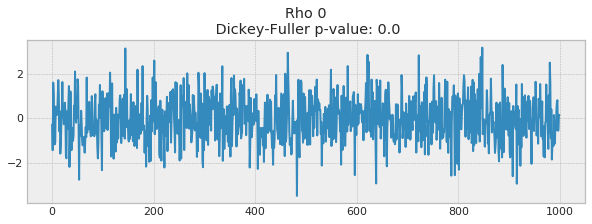

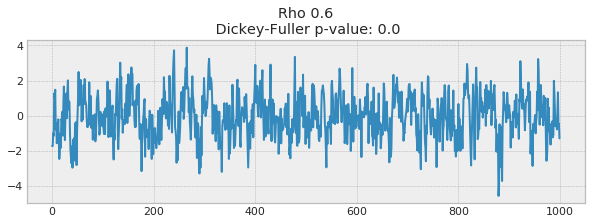

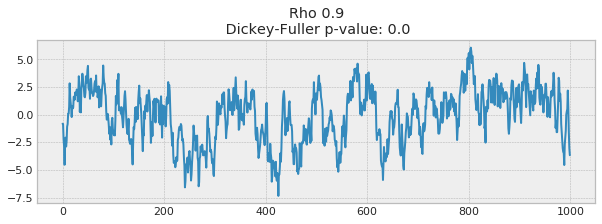

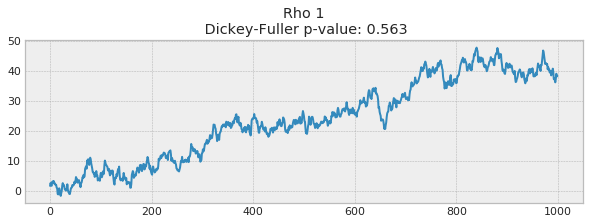

In [38]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho,
                                                              round(sm.tsa.stattools.adfuller(x)[1], 3)))


for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

在第一张图上，你可以看到和之前一样的高斯白噪声。在第二张图将 $\rho$ 增加至 0.6，大周期开始出现，但整体仍然相对静止。第三幅图更偏离均值，但仍在均值附近振荡。最后，随着 $\rho$ = 1，便得到一个随机过程，即非平稳的时间序列。

在达到临界值后，序列 $x_t = \rho x_{t-1} + e_t$不会回归其平均值。如果从两边减去 $x_{t-1}$，将得到 $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$，其中左边的表达式被称为一阶差分。如果 $\rho=1$，那么一阶差分为白噪声 $e_t$。这是 [<i class="fa fa-external-link-square" aria-hidden="true"> Dickey-Fuller</i>](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) 测试时间序列平稳性背后的主要思想，即检验是否存在单位根，这里的单位根指的是 $\rho=1$。如果可以使用一阶差分从非平稳序列中得到一个平稳序列，则称这些序列为一阶差分序列。

消除时间序列非平稳性的方法有很多，常用的有：多阶差分、移除趋势和季节性去除、平滑，以及 Box-Cox 或对数等转换。

### 摆脱非平稳性并构建SARIMA

SARIMA( Seasonal Autoregressive Integrated Moving Average ) 季节性差分自回归滑动平均模型。是常用的时间序列预测分析方法之一。该方法可以对任何周期的时间序列进行建模。因此，在时间序列分析中得到了广泛的应用。

因为 SARIMA 的部分参数需要根据自相关图和偏自相关图来进行选取。相关性指的是两个向量得相关程度，一般用皮尔逊系数来衡量。自相关就是时间序列本身与延后的时间序列的相关性。而偏自相关则是剔除干扰后时间序列观察与先前时间步长时间序列观察之间关系的总结。所以先定义画出时间序列图及其自相关图和偏自相关图的函数。

In [39]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    画出时间序列的图形
    y - 时间序列
    lags - 延迟大小
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y.values)[1]
        ts_ax.set_title(
            'Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

画出广告数据的自相关图和偏自相关图。

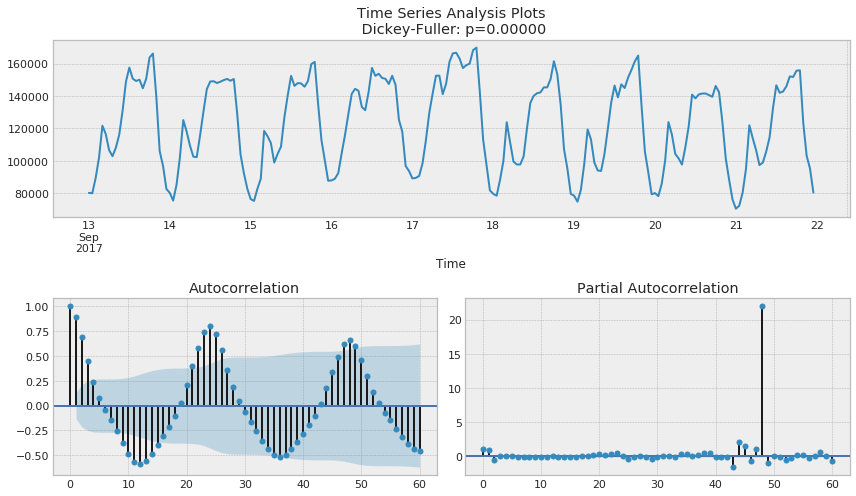

In [40]:
tsplot(ads.Ads, lags=60)

出乎意料，初始序列是平稳的，也就是是说单位根不存在。实际上，可以在图上看到，没有明显的趋势，均值是常数，方差非常稳定。唯一剩下的是季节性，在建模之前需要处理它。为了做到这一点，让我们取「季节差分」，将本身的序列减去延后一个季节的序列。

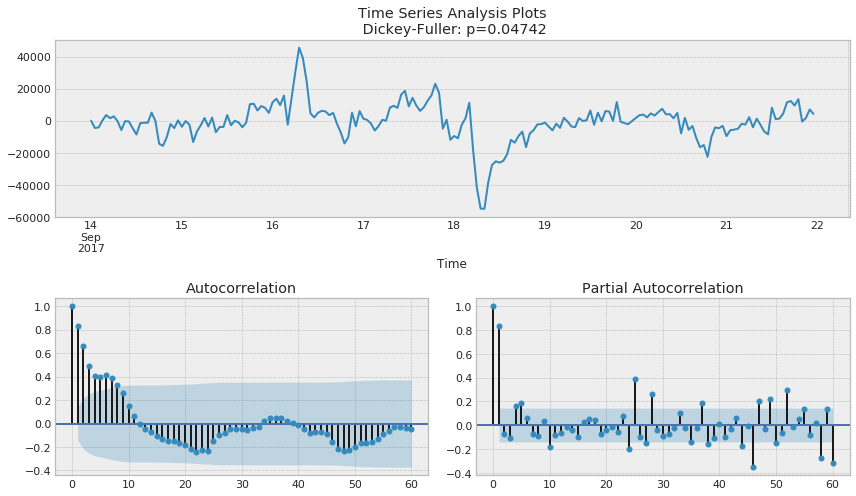

In [41]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

随着明显的季节性消失，现在情况好多了。然而，自相关函数仍然有太多的显著延后。要消除它们，我们对序列进行一阶的差分。

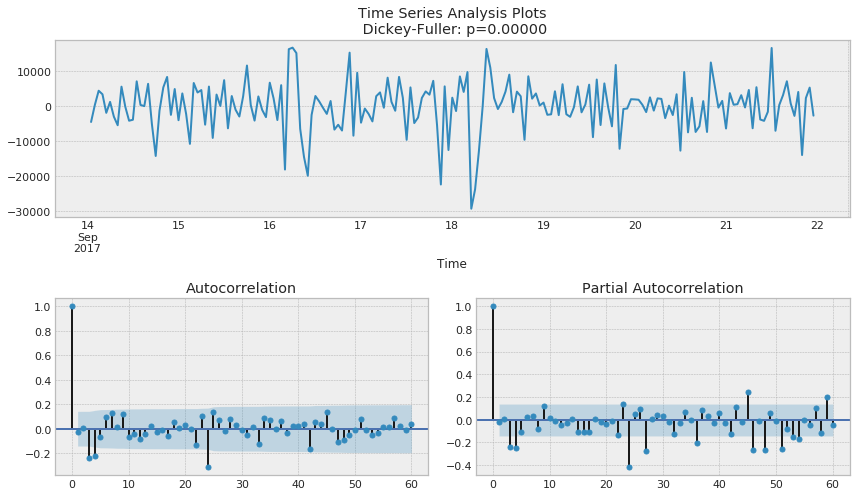

In [42]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

现在，自相关函数现在看起来好许多，在0附近振荡。Dickey-Fuller 检验表明，ACF 是平稳的，减少了显著的峰值。现在可以开始建模。

### ARIMA

现在开始讲解建模：建模通常最常用的是 $SARIMA(p, d, q)(P, D, Q, s)$。

- $AR(p)$ - 自回归模型，时间序列自身的回归。这有一个基本的假设，即某个序列值仅依赖与它之前的某个窗口范围的值。在模型中，滞后大小记为 $p$。要确定 $p$ 的初始值。需要去画出偏自相关 PACF 图，查看 PACF 图并找到最大的显著滞后。

- $MA(q)$ - 移动平均模型，同样假设当前的误差依赖于之前的误差，并带有一定的滞后，即 $q$ 。初始值可以在自相关 ACF 图上找到。

把四个字母连接起来：

$$AR(p) + MA(q) = ARMA(p, q)$$

这里有自回归模型，移动平均模型。如果序列是平稳的，它可以用这四个字母近似。

- $I(d)$ - 差分。这只是使序列平稳所需的非季节性差异的数量。在我们的例子中，只有 1，因为我们用了一阶差分。

加上这个字母，则得到 $ARIMA$ 模型，它可以在非季节性差异的帮助下处理非平稳数据。

- $S(s)$ -负责季节性，等于序列的季节性周期长度


这样，模型会有三个参数 $(P, D, Q)$：

- $P$ - 模型季节分量的自回归阶数，可由 PACF 得到。但是，需要查看显著滞后的数量，这是季节周期长度的倍数。例如，如果周期等于 24，我们看到第 24 和 48 次滞后在 PACF 中是显著的，这意味着初始的 $P$ 应该是 2。

- $Q$ - 与 $p$ 的选择类似，使用 ACF 图来得到。

- $D$ - 季节差分。这可能等于 1 或 0 ，取决于是否应用了季节差分。

现在知道了如何设置初始参数，让我们再看一遍最终的图并设置参数:

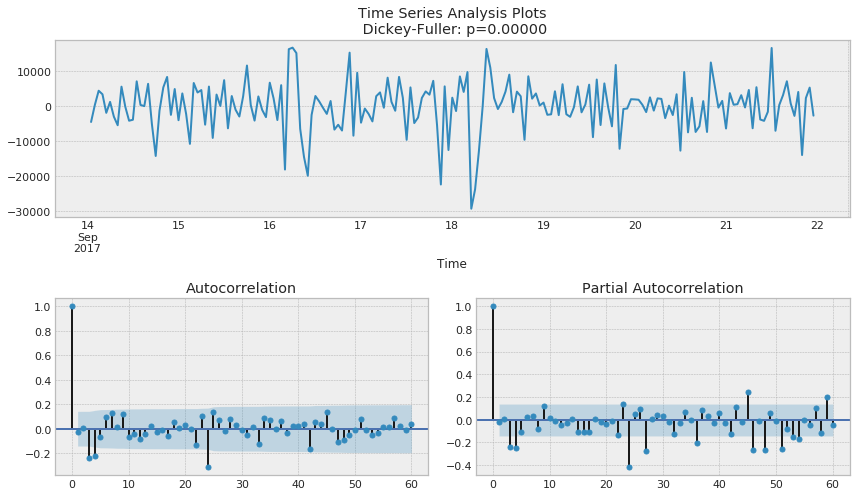

In [43]:
tsplot(ads_diff[24+1:], lags=60)

- $p$ 最可能是4，因为 4 是 PACF 的最后一个显著滞后，在此之后，其他大多数都不显著。
- $d$ 等于 1，因为我们有一阶差分
- $q$ 应该在 4 左右，就像在ACF上看到的那样
- $P$ 可能是2，因为 24 和 48 的滞后对 PACF 有一定的影响
- $D$ 还是等于1，因为我们做了季节差分
- $Q$ 可能是 1，ACF 的第 24 个延迟显著，而第 48 个延迟不显著。

现在测试不同的参数，看看哪个更好。设置不同的参数值。

In [44]:
# 设置初始值
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24  # 季节性长度任然是 24

# 使用所有可能的参数组合创建列表
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

定义寻找 SARIMA 模型最优参数函数：

In [45]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
    返回带有参数和相应 AIC 的 DataFrame
    parameters_list - 元组 (p, q, P, Q) 
    d - 差分
    D - 季节性差分 
    s - 季节长度
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # 我们需要try-except因为在一些组合模型上不能收敛
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], s), freq="H").fit(disp=-1)
        except:
            continue
        aic = model.aic
        # 保存最佳模型、AIC 和参数
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # 按升序排序，AIC 越低越好
    result_table = result_table.sort_values(
        by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [46]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [47]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


构建 SARIMA 模型，并归广告数据进行预测。

In [48]:
# 设置参数
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s), freq="H").fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Tue, 21 May 2019   AIC                           3888.642
Time:                                    06:21:13   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

画出模型预测结果的自相关图和偏自相关图：

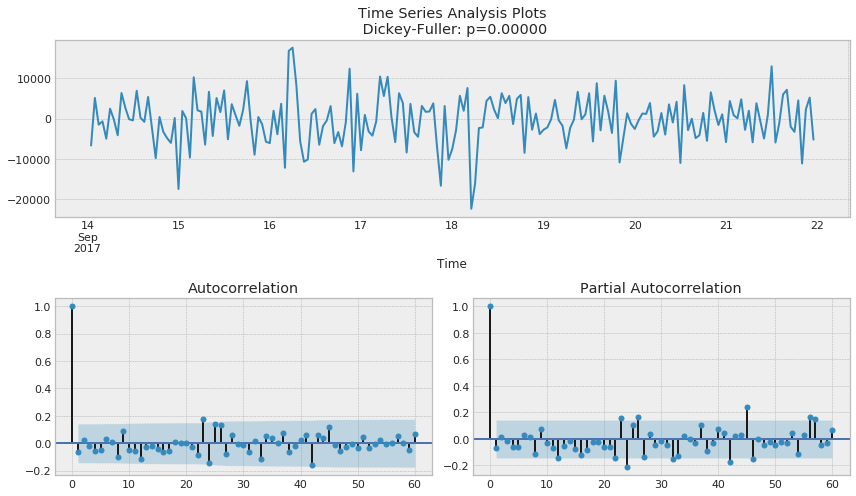

In [49]:
tsplot(best_model.resid[24+1:], lags=60)

很明显，一阶差分是平稳的，没有明显的自相关性。

定义画出 SARIMA 预测结果的函数。

In [50]:
def plotSARIMA(series, model, n_steps):
    """
    画图并预测
    series - 时间序列
    model - 模型
    n_steps - 预测的长度
    """
    # 复制数据
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # 对s+d步骤进行转换，因为模型没有观察到这些值，由于微分
    data['arima_model'][:s+d] = np.NaN

    # 对n_steps进行预测
    forecast = model.predict(start=data.shape[0], end=data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # 计算误差，从一开始就在s+d步上移动
    error = mean_absolute_percentage_error(
        data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1],
                alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

画出广告数据的预测结果。

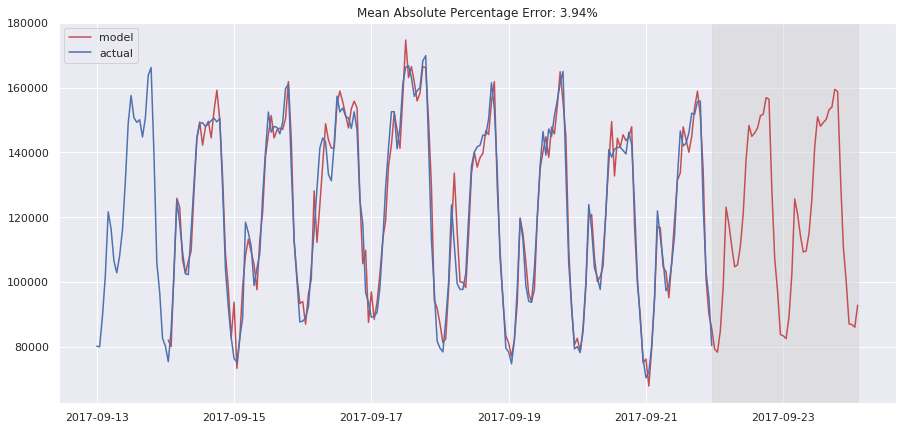

In [51]:
plotSARIMA(ads, best_model, 50)

最后，得到了非常充分的预测。模型平均误差是 4.01%，这是非常好的结果。然而，准备数据和使序列平稳以及选择参数可能需要花费巨大的时间成本。因此，有时候该方法可能并不值得。

### 时间序列上的线性模型

通常，在我们的工作中，一般以 [<i class="fa fa-external-link-square" aria-hidden="true"> 快准好</i>](http://fastgood.cheap) 作为唯一的指导原则来构建模型。这意味着，其中一些模型永远不会被认为是「随时可用」的，因为它们需要太多的时间进行数据准备，或者需要对新数据进行频繁的再训练，或者很难调优。因此，从现有的时间序列中选择几个特性，并构建一个简单的线性回归模型，或者说是一个随机森林，往往要容易得多。又好又简单。

这种方法没有理论支持，并且打破了几个假设。例如，高斯-马尔可夫定理，特别是在误差不相关的情况下。尽管这样，这种方法在实践中仍然非常有用，而且经常用于机器学习竞赛。

#### 特征提取

机器学习模型的输入需要特征，而时间序列只是一个一维的序列数据。那么可以提取哪些特征?一般我们可以从时间序列中提取如下特征：

- 时序的时差
- 窗口统计：
    - 序列在一个窗口中的最大最小值
    - 一个窗口中的中值和平均值
    - 窗口的方差
    - 等等
- 时间特征：
    - 年月日，时分秒
    - 假期、特殊的节日
- 目标编码
- 其他模型的预测结果

#### 时序的时差

将序列往后移动 n 步，我们能得到一个特征。如果移动 1 个时差，并训练模型，那么模型将能够提前预测1步。增加时差，比如，增加到 6，可以让模型提前预测 6 步，不过它需要在观测到数据的 6 步之后才能利用。如果在这期间序列发生了根本性的变动，那么模型无法捕捉这一变动，会返回误差很大的预测。因此，时差的选取需要平衡预测的质量和时长。

创建副本数据来进行各种转换。

In [52]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

添加时差为 6 到 24 的差分值。

In [53]:
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

查看数据的后 7 个数据。

In [54]:
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


通过上面的构建，获得了一份特征集，现在利用该特征集来进行训练模型。

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# 对时间序列进行5折交叉
tscv = TimeSeriesSplit(n_splits=5)

定义划分训练集和测试集的函数。

In [56]:
def timeseries_train_test_split(X, y, test_size):
    """
    根据时间序列结构进行训练集和测试集的分割
    """
    # 设置测试集开始的坐标
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

划分训练集和测试集，测试集采用 30%的数据。

In [57]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# 预留 30% 的数据用于测试
X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

构建线性回归模型。

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

定义画出线性回归预测结果图的函数。

In [59]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
    画出模型、事实值、预测区间和异常值的图表
    """
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 4))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

定义画出特征值重要性的函数：

In [60]:
def plotCoefficients(model):
    """绘制模型的排序系数值
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 4))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

画出线性回归模型的预测结果。

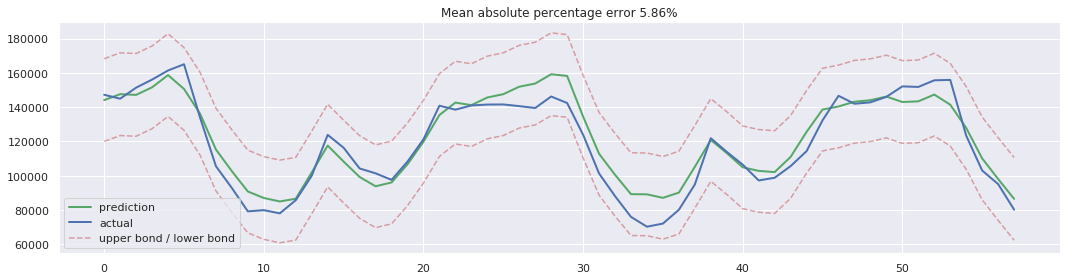

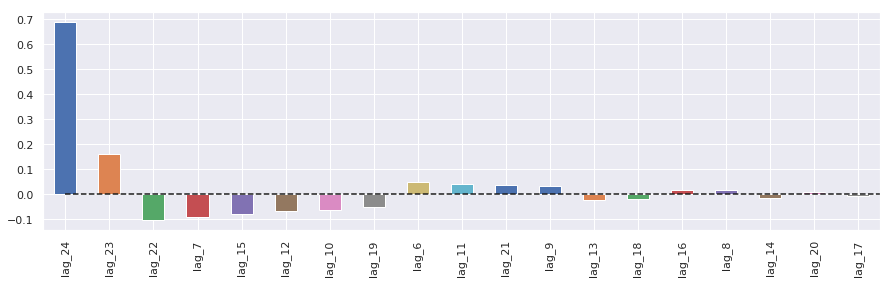

In [61]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

通过简单的时差处理，利用线性回归模型的预测结果基本接近 SARIMA 模型。

现在提取更多的特征，添加小时、日期、是否是周末等特征值。

In [62]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


可视化这些特征，看看我们可以从广告数据中提取什么。

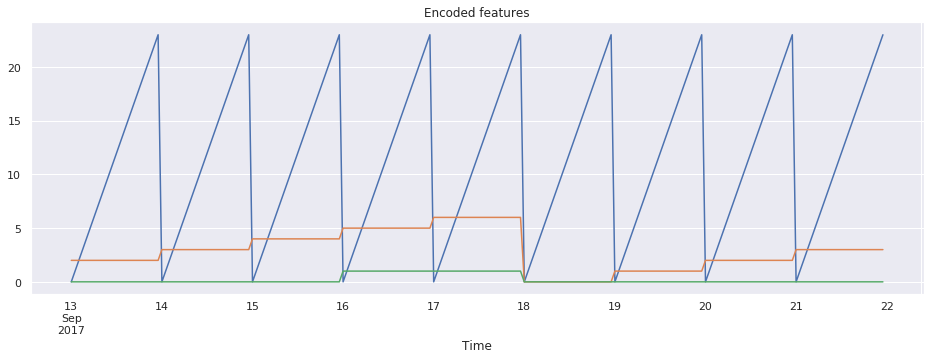

In [63]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

由于构建的数据有不同的尺度，时差特征有数千个，其他类别特征有数十个，因此需要将它们转换为相同的尺度，以探索特征的重要性，然后再进行正则化。

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

先对特征进行标准化，再输入到模型进行预测。

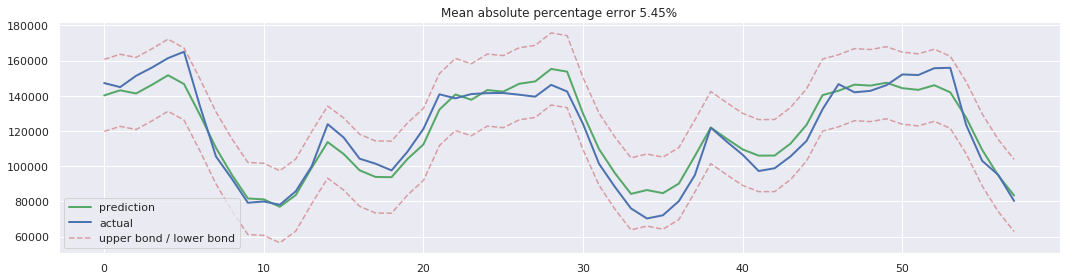

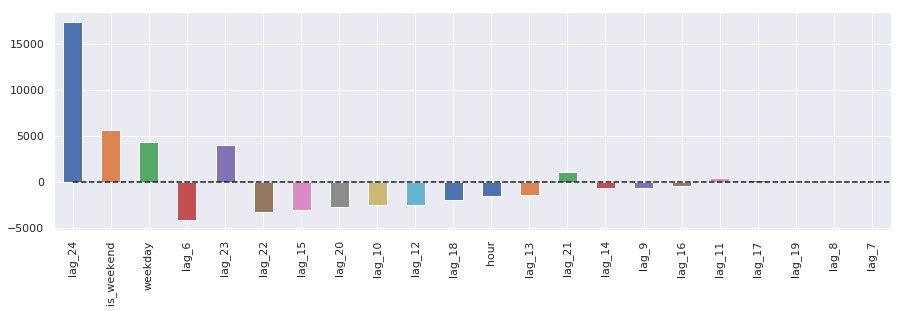

In [65]:
import sys
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train.astype(float))
X_test_scaled = scaler.transform(X_test.astype(float))

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled,
                 X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

从图中可以看出，测试误差下降了一点。从系数图可以看出，工作日和是否是周末是有用的特征。

#### 目标编码

目前，许多机器学习算法并不能直接处理类别型数据。因此在构建机器学习模型之前，要将类别型特征转化为数值型特征。

这里介绍一种编码类别特征的版本: 按平均值编码。按平均值编码指的是用目标变量的平均值进行编码。在我们的示例中，一周中的每一天和一天中的每一个小时都可以由当天观看的广告的平均数量进行编码。

In [66]:
def code_mean(data, cat_feature, real_feature):
    """
    返回一个字典，其中键是cat_feature的唯一类别，
    并且它的值是real_feature上的平均值
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

按 1 小时观看广告数的平均值进行编码。

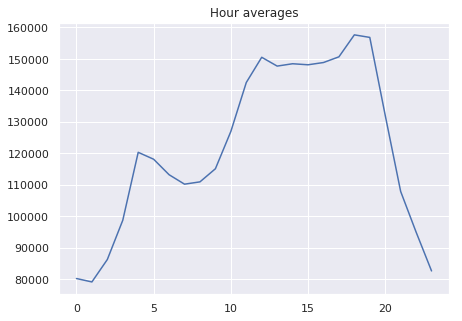

In [67]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True)

定义一个函数，完成所有的编码转换。

In [68]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
    series: 时间序列
    lag_start: 差分的最小窗口值 
    lag_end: 差分的最大窗口值
    test_size:测试集的比例
    target_encoding: 布尔值，如果为True,则向数据集中添加目标平均值
    """

    # 复制数据
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # 创建时间索引
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6])*1

    if target_encoding:
        # 计算平均
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(
            map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(
            map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # 删掉原来的特征
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # 训练集和测试集划分
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size)

    return X_train.astype(float), X_test.astype(float), y_train, y_test

完成编码，然后进行标准化，最后进行训练，并画出结果图。

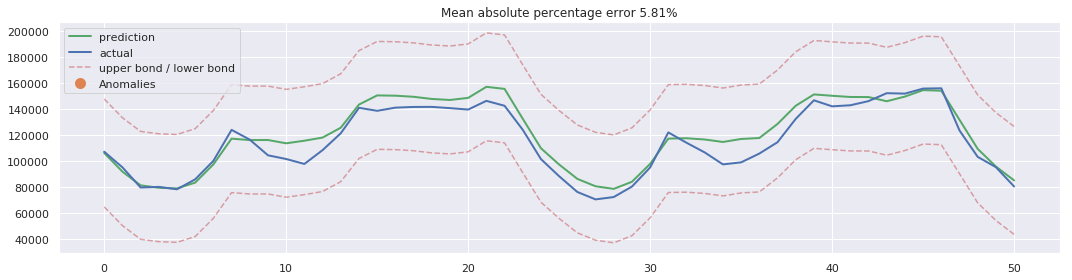

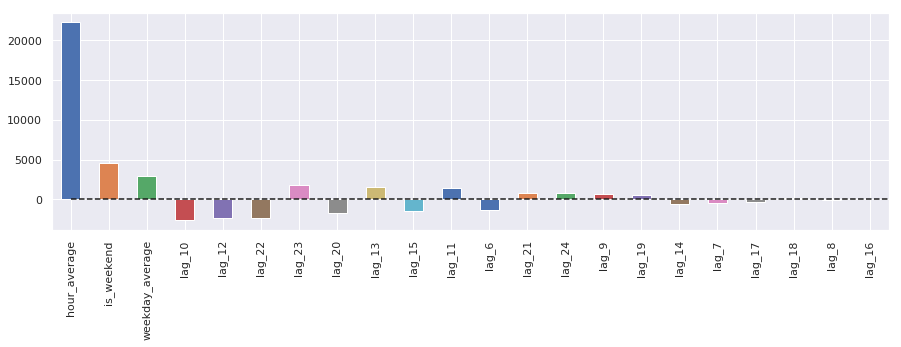

In [69]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25,
                                               test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

从上图可以看到有些过拟合了，这个问题可以用多种方法来解决。例如，不对整个时间序列进行编码，而只针对某个窗口。这样，来自最后一个观察到的窗口的编码可能会更好地描述当前序列状态。

In [70]:
X_train, X_test, y_train, y_test =\
    prepareData(ads.Ads, lag_start=6, lag_end=25,
                test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 正则化和特征选择

正如前文所描述的，并不是所有的特征都是有用的，有些特征可能会导致过度拟合，有些特征则应该删除。除了人工检查，我们还可以采用正则化。目前，两种最流行的正则化回归模型是 Ridge 和 Lasso 回归。它们都给损失函数增加了一些约束。

Ridge 通常也被称为 L2正则化。Ridge 回归可以看成是最小二乘法的一个补充。Ridge 的损失函数主要由两项构成，分别是均方差损失和正则化项，正则化项是对系数的平方进行惩罚。因此，Ridge 通常也被称为 L2正则化。换句话说，一个特征的系数越大，损失函数值就越大。因此，模型在优化的同时，也保持系数相当较小。

Lasso 回归于 Ridge 类似。损失函数同样是由均方差损失和正则化项组成。所不同的是 Lasso 的正则化项是对系数的绝对值进行惩罚。所以通常 Lasso回归也被称为 L1 正则化。

先通过热图来查看特征之间的相关性。

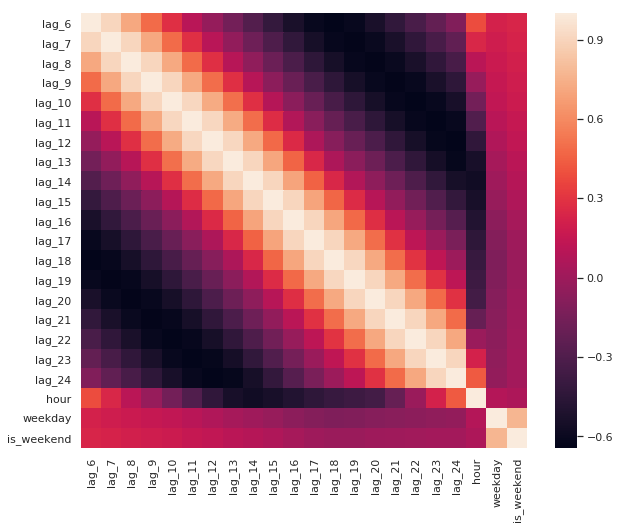

In [71]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr())

使用 Ridge 回归进行预测，并画出每个特征的重要性。

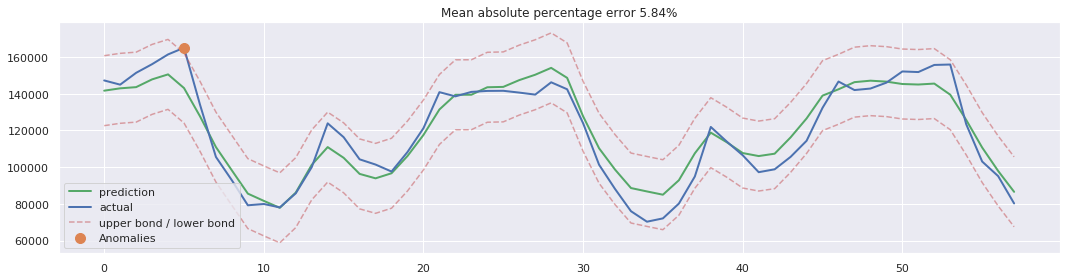

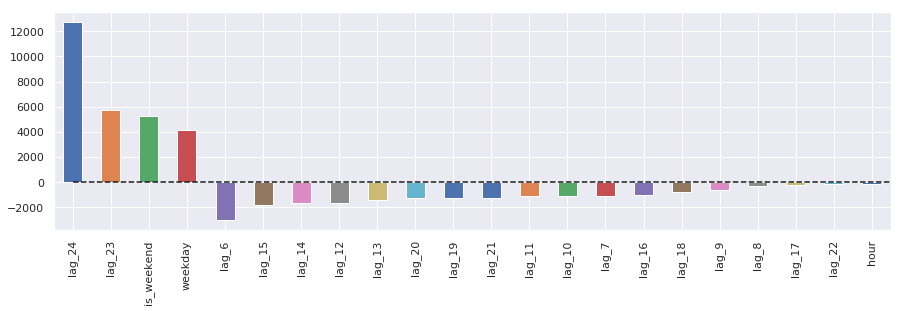

In [72]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

从上图中，可以清楚地看到，特征 lag_24 的系数最大，这也意味着该特征比较重要，随着特征在模型中的重要性的降低，系数越来越接近零。

同样的方法使用 Lasso 进行实验。

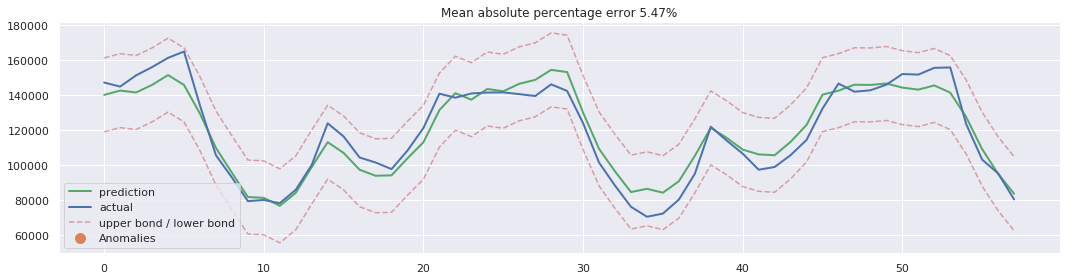

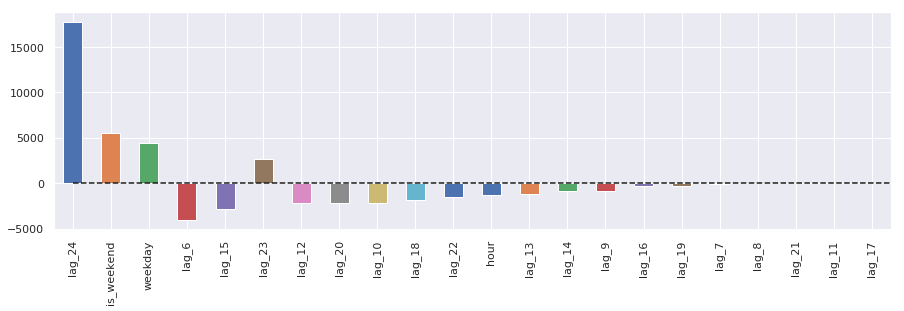

In [73]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                 X_train=X_train_scaled,
                 X_test=X_test_scaled,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

从上图的 Lasso 回归结果显示更可以看出，该方法没有将特征 lag_23 作为重要特征。同时也完全剔除了 5 个特征，这提高了预测的质量。

#### XGBoosting

XGBoost 是一种梯度提升方法。由于其出色的性能而被广泛的应用。现在同样的问题采用 XGBoost 来解决。

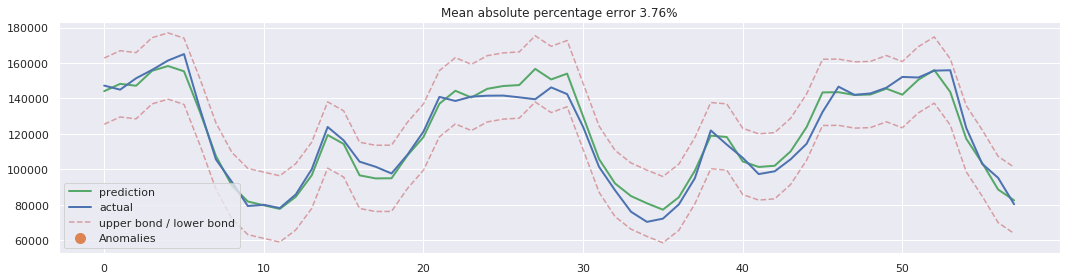

In [74]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(np.array(X_train_scaled), y_train)
plotModelResults(xgb,
                 X_train=np.array(X_train_scaled),
                 X_test=np.array(X_test_scaled),
                 plot_intervals=True, plot_anomalies=True)

从上面的结果可知，XGBoost 的拟合结果明显优于前文所使用的模型。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033654315">

通常，与线性模型相比，基于树的模型处理数据趋势的能力较差，而XGBoost的基模型正是决策树。所以在这种情况下，必须先消除时间序列数据的趋势，或者使用一些特殊的技巧。一般情况下，可以使用线性模型来预测趋势，然后将其加入XGBoost 的预测得到最终预测结果。

### Prophet

上文主要介绍了 SARIMA 模型以及机器学习方法。在时间序列处理中，还有一种常用的方法，那就是 FaceBook 开源的 Prophet。

根据 Facebook 研究的 [<i class="fa fa-external-link-square" aria-hidden="true"> 文章</i>](https://research.fb.com/prophet-forecasting-at-scale/)，Prophet 最初是为了创建高质量的商业预测而开发的。这个库试图去解决目前许多业务时间序列常见的困难，如下:

- 人类行为导致的季节性效应：周、月、年循环，公共假期的峰谷。
- 新产品和市场事件导致的趋势变动。
- 离群值。

Prophet 官方声称，即使仅使用默认的参数设置，在许多情况下，Prophet 生成的预测与经验丰富的分析师提供的预测一样准确。

此外，Prophet 有许多直观且易于解释的定制功能，以供逐步改善模型预测的质量。尤其重要的是，即使对于不是拥有一定技能和经验的数据科学家来说，也可以理解这些参数的意思。

根据文章所言，Prophet 的适用对象和场景很广泛，如下：

- 面向广泛的数据分析师群体，这些数据分析师可能在时序领域没有很多经验。
- 面向广泛的时间序列预测问题。
- 自动估计大量预测的表现，包括标出可能的问题，以供分析师进一步调查。

#### Prophet 预测模型

Prophet 性能这么优越，那么它是怎么实现的呢？其实 Prophet 在本质上是一个加性回归模型，如下式所示：

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$

-  $g(t)$ 负责预测非周期性趋势
-  $s(t)$ 负责预测周期性.
-  $h(t)$ 负责假期和特殊事件等信息.
-  $\epsilon_{t}$ 表示误差

下面来讨论这些重要的概念

#### 趋势

Prophet 中提供了两种趋势模型。

第一种是非线性饱和增长模型，通常也称为 [<i class="fa fa-external-link-square" aria-hidden="true"> 逻辑增长模型</i>](https://en.wikipedia.org/wiki/Logistic_function)，其表达式如下：

$$g(t) = \frac{C}{1+e^{-k(t - m)}}$$

在上式中：

- $C$ 表示承载量，也就是曲线的最大值
- $k$ 表示增长率，也就是曲线的陡峭程度
- $m$ 表示偏置参数.

逻辑增长模型可以使用在非饱和增长（也就是增长率随时间而下降）的数据类型中，一个典型的例子就是 APP 或网站的用户增长。

事实上，$C$ 和 $k$ 不一定是一个常量，可能会随时间的移动而变化。Prophet 支持自动或手动调整这两个参数。因为 Prophet 本身可以通过拟合历史数据来选择趋势变化的最优点。

当然，也可以手动指定增长率和承载量变动的时间点。例如，分析师可能对过去的发布日期有深刻的见解，这些日期对一些关键的产品指标产生了显著的影响。

第二种趋势模型是增长率恒定的简单分段线性模型，适合不存在饱和的线性增长数据。

#### 季节性

对于具有季节性周期变化的时间序列来说，Prophet 提供了一种灵活的模型 $s(t)$ 。

每周的季节性数据是通过虚拟变量来进行建模的。也就是添加了六个新变量: 星期一、星期二、星期三、星期四、星期五、星期六，它们的值可以取为取 0 或 1。这里没有添加周日变量，因为它可以表示为一周中其他时间的线性组合。

年季节性通过傅里叶级数进行建模。

 Prophet 的 0.2 版加入了新的日季节性特性，可以使用日以下尺度的时序数据，并做出日以下尺度的预测。

#### 假期和事件

Prophet 提供的 $h(t)$ 可以预测时间序列中哪些特殊的日期，例如黑色星期五。要使用 $h(t)$，分析人员需要提供自定义的事件列表。

#### 误差

误差项 $\epsilon_{t}$ 表示的是所构建的模型中未反映的信息，一般取高斯噪声。

#### Prophet 模型

关于 Prophet 更多的细节，可以阅读由 Sean J、 Taylor 和 Benjamin Letham 等人所写的[<i class="fa fa-external-link-square" aria-hidden="true"> 这篇论文</i>](https://peerj.com/preprints/3190/) 

在 Facebook 的论文中，将 Prophet 与其他算法进行对比，并使用平均绝对百分比误差来衡量预测结果。结果显示，Prophet 拥有更低的误差。

<img src="https://doc.shiyanlou.com/courses/uid214893-20190505-1557033673417">

为了便于理解上面的评测结果，先来简单温习一下平均绝对百分误差（MAPE）的概念。

假定 $y_i$ 为真实值，而 $\hat{y}_{i}$ 为模型所预测的值。则预测误差为 $e_{i} = y_{i} - \hat{y}_{i}$ ，相对误差为 $p_{i} =\frac{\displaystyle e_{i}}{\displaystyle y_{i}}$。因此，平均绝对百分误差（MAPE）可以定义为：

$$MAPE = mean\big(\left |p_{i} \right |\big)$$

MAPE 以百分比表示误差，可用于不同数据集的模型评估，也被广泛应用于检测模型预测结果的精确性。

此外，当需要知道误差的绝对值时，可以使用下式来计算 [<i class="fa fa-external-link-square" aria-hidden="true"> 平均绝对误差</i>](https://en.wikipedia.org/wiki/Mean_absolute_error)：

$$MAE = mean\big(\left |e_{i}\right |\big)$$

简单讲述一下与 Prophet 做比较的算法。它们中的大多数都非常简单，而且经常被用作其他模型的基线:

- naive 是一个过度简化的预测方法，仅仅根据上一时间点的观测数据来预测所有未来值。
- snavie，类似 naive，不过考虑了季节性因素。例如，在周季节性数据的情形下，用上周一的数据预测未来每周一的数据，用上周二的数据预测未来每周二的数据，以此类推。
- mean 使用数据的平均值作为预测。
- arima 是自回归集成移动平均的简称，参见 [<i class="fa fa-external-link-square" aria-hidden="true"> 维基百科</i>](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)了解这一算法的细节。
- ets 是指数平滑的简称，参见 [<i class="fa fa-external-link-square" aria-hidden="true"> 维基百科</i>](https://en.wikipedia.org/wiki/Exponential_smoothing)了解详情。

现在通过举一个例子来进行说明，并使用 Prophet 进行实践。

#### 安装 Prophet

要想使用 Prophet 这个库来进行数据分析，就先要对其进行安装。目前 Prophet 主要支持 Python 与 R 语言。如果你想在自己的电脑上装 Prophet 。则 Python 版本可以使用下面命令安装：`$ pip install fbprophet`。

#### 数据集

我们将预测每天在 [<i class="fa fa-external-link-square" aria-hidden="true"> Medium</i>](https://medium.com/) 上发表的文章数量。

首先 先导入实验所需的数据。

In [75]:
df = pd.read_csv(
    '../../data/medium_posts.csv.zip', sep='\t')
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


首先对数据进行预处理。在该数据集中，pubilished 为发布日期，而 url 为文章的唯一标识。这里保留 pubilished 和 url 这两列特征，而删除这两列之外的所有列。此外，删掉数据中存在的重复值和缺失值:

In [76]:
df = df[['published', 'url']].dropna().drop_duplicates()

现在将 pubilished 转换为时间索引。

In [77]:
df['published'] = pd.to_datetime(df['published'], utc=False)

然后通过时间来排序数据。

In [78]:
df.sort_values(by=['published']).head(n=3)

,published,url
50931,1970-01-01 00:00:00.001,https://medium.com/iiot
40243,1970-01-01 00:00:00.001,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


Medium 的公开发行日期是 2012 年 8 月 15 日。但是，从上面的数据可以看到，至少有几行具有更早的发布日期。它们以某种方式出现在我们的数据集中，但它们几乎不是合法的。所以只保留 2012 年 8 月 15 日至 2017 年 6 月 25 日期间的数据。

In [79]:
df = df[(df['published'] > '2012-08-15') & (df['published']
                                            < '2017-06-26')].sort_values(by=['published'])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-social...


查看数据的最后3行。

In [80]:
df.tail(n=3)

,published,url
62122,2017-06-25 23:36:01.171,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43.000,http://www.johanr.com/blog/people-support-dreams


由于这里要预测已发布的文章数量，所以要统计每个时间点发布的文章数量。并新建 post 列来存放。

In [81]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']
aggr_df.head(n=3)

,posts
published,
2012-08-15 00:25:03.373,1
2012-08-15 00:25:29.419,1
2012-08-15 00:34:59.502,1


在这个实验中，想要预测的是每天文章发布的数量。但是现在的数据的时间间隔并不是一天。为了解决该问题，需要根据时间「箱」来聚合文章数，即把一天中所发表的文章数相加起来。在时序分析中，这一过程称为重采样。并且，如果降低了数据的采样率，那么这个过程称为降采样。

In [82]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4


#### 可视化分析数据

通过可视化，可以观察数据的季节性和一些明显异常偏差等信息。现在导入画图所必须的库。

In [83]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

定义画图函数：

In [84]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

画出 Medium 数据集时间序列图：

In [85]:
plotly_df(daily_df, title='Posts on Medium (daily)')

相对来说，高频数据是比较难分析。即使有了 Plotly 提供的放大功能，除了显著的上升和加速趋势外，也很难从这张图表中推断出任何有意义的东西。

为了减少噪音，这里使用与之前同样的方法将日索引转换为周索引。当然，除了这种方法，也可以使用[<i class="fa fa-external-link-square" aria-hidden="true">移动平均平滑</i>](https://en.wikipedia.org/wiki/Moving_average)和[<i class="fa fa-external-link-square" aria-hidden="true">指数平滑</i>](https://en.wikipedia.org/wiki/Exponential_smoothing)等方法来消除噪声。

In [86]:
weekly_df = daily_df.resample('W').apply(sum)
plotly_df(weekly_df, title='Posts on Medium (weekly)')

从图中可以看到，换成周索引之后，数据的噪音要减小很多。也更利于分析。

由上图可知，2015 年之前的数据很小，很可能会对预测模型造成干扰，因为模型将被迫去适应这些异常的历史数据。因此仅用 2015 年之后的数据。

In [87]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head(n=3)

,posts
published,
2015-01-01,8
2015-01-02,11
2015-01-03,11


综上所述，从可视化分析可以看出，我们的数据集是非平稳的，并且有明显的增长趋势。它还显示了每周和每年的季节性和每年的一些异常的日子。

#### 构建预测模型

Prophet 提供 API 与 scikit-learn 提供的 API 非常相似。首先创建一个模型，然后调用方法 `fit`，最后进行预测。方法 `fit` 的输入是一个 DataFrame，包含两列:

- ds 为时间戳，且必须是 date 或 datetime 类型。
- y  为要预测的数值。

先导入 Prophet 等实验所必须的库：

In [88]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

重置数据的索引：

In [89]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


Prophet 的官方通常建议至少根据最新的几个月的历史数据来做出预测。当然，理想情况下是一年以上的数据。不过，在我们的例子中，有超过几年的数据来训练模型。所以无需担心这一问题。

为了度量模型预测的质量，需要将数据集划分为训练部分和预测部分。测试部分取最后一个月。

In [90]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


现在需要去创建一个新的 Prophet 模型。在这里，模型的参数选用默认值。然后在训练数据集上调用模型的 `fit` 方法来训练模型。

In [91]:
m = Prophet()
m.fit(train_df)

这里可以使用 `Prophet.make_future_dataframe` 来创建用于预测的时间信息。

In [92]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


使用 Prophet 将创建的日期来预测未来三十天的值。如果我们也提供历史数据，那么除了预测未来值之外，还将得到一个适合历史的样本预测数据。让我们调用模型的 `predict` 方法来进行预测：

In [93]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,276.049274,251.211755,302.945913,275.739204,276.451558,2.359168,2.359168,2.359168,3.478804,3.478804,3.478804,-1.119637,-1.119637,-1.119637,0.0,0.0,0.0,278.408441
905,2017-06-24,276.750096,217.975539,266.610956,276.417651,277.176730,-34.950170,-34.950170,-34.950170,-34.026715,-34.026715,-34.026715,-0.923455,-0.923455,-0.923455,0.0,0.0,0.0,241.799926
906,2017-06-25,277.450918,220.527041,270.371419,277.082002,277.899216,-31.310676,-31.310676,-31.310676,-30.582721,-30.582721,-30.582721,-0.727955,-0.727955,-0.727955,0.0,0.0,0.0,246.140241


在得到的数据中，可以看到许多列描述了许多预测结果的特性，包括趋势和季节性组件以及它们的置信区间。预测结果存储在 yhat 列中。

Prophet 库内置有自己的可视化工具，使我们能够快速地评估结果。

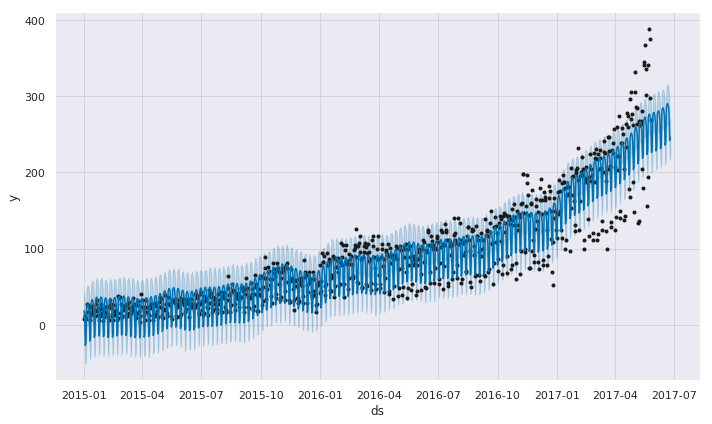

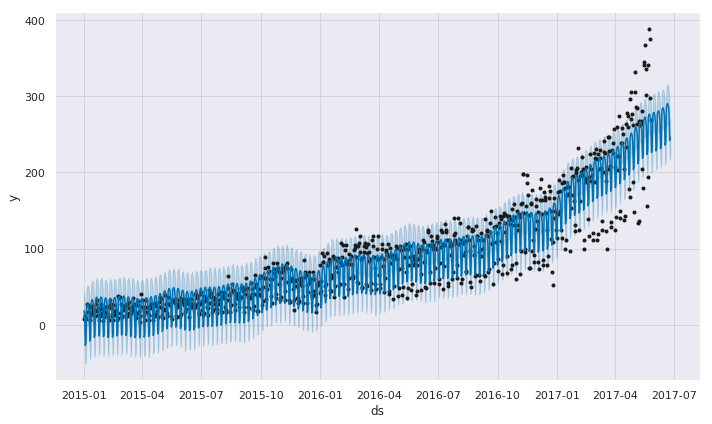

In [94]:
m.plot(forecast)

这张图表看起来信息量不大。但从图中任然可以得出一个结论：该模型将许多数据点视为异常值。

为了看到更加详细的信息，可以使用 `Prophet.plot_components`来观察模型的不同组成部分。例如: 趋势、年和周季节性。此外，如果向模型提供关于假日和事件的信息，它们也将显示在这个图中。

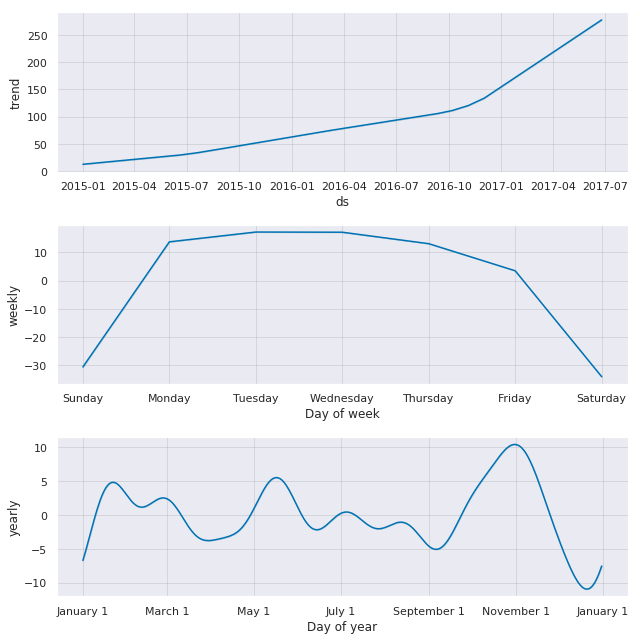

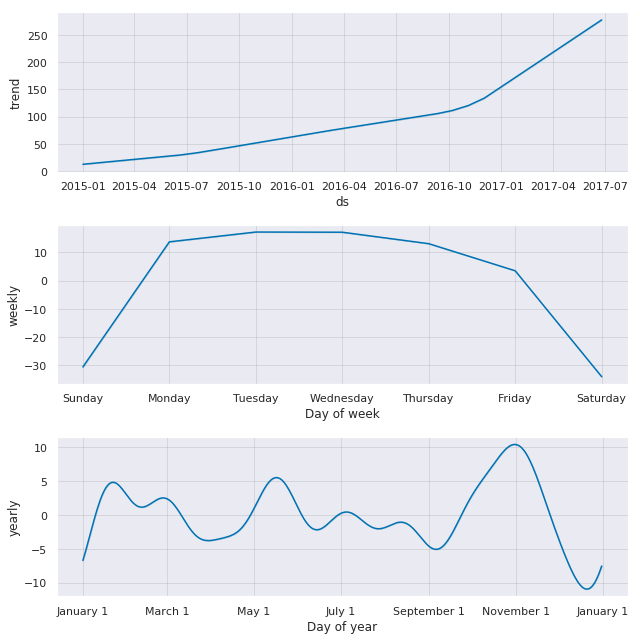

In [95]:
m.plot_components(forecast)

从趋势图中可以看出，在 2016 年底新文章的数量呈加速增长趋势。从周季节性图表可以看出，通常周六和周日的新文章比一周的其他时间要少。年季节性图表中，新文章数在圣诞节有一个明显的下降。

#### 预测结果质量评估

假定真实值为 $y_i$ ，模型预测结果为 $\hat{y}_i$，则可以通过衡量真实值与预测值的误差来评估模型的质量。先来看 Prophet 预测结果的有哪些信息。

In [96]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


可以看到，除了历史值之外，这个数据基本包含了我们需要的所有信息。在模型评估中，只需要预测结果数据，即 $\hat{y}_i$ 。因此定义一个提取 $\hat{y}_i$ 及其置信区间的函数。

In [97]:
def make_comparison_dataframe(historical, forecast):
    """返回只含三列的数据 'yhat', 'yhat_lower', 'yhat_upper'
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

使用之前定义的函数查看预测结果。

In [98]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,278.408441,251.211755,302.945913,421
2017-06-24,241.799926,217.975539,266.610956,277
2017-06-25,246.140241,220.527041,270.371419,253


现在使用前面所述的 MAPE 和 MAE 评价指标来衡量模型的预测质量，先定义一个评价函数：

In [99]:
def calculate_forecast_errors(df, prediction_size):
    """计算模型预测结果的 MAPE 和 MAE
    Args:
       df: 含 'y' 和 'yhat' 的 DataFrame.
       prediction_size: 预测数据的长度.
    """

    df = df.copy()

    # 现在我们根据上面文章给出的公式计算e_i和p_i的值
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']

    # 划分测试序列.
    predicted_part = df[-prediction_size:]

    # 定义求 MAPE 函数。
    def error_mean(error_name): return np.mean(
        np.abs(predicted_part[error_name]))

    # 通过字典返回
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

使用评价函数对模型的预测结果进行评价。

In [100]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.738294605590088
MAE 70.52942851097268


从上面的结果可知，模型的预测相对误差 MAPE 约为 22.72%，平均误差 MAE 为 70.45。

#### 可视化

现在创建自己的可视化函数来画出模型的一些信息，包括实际值、预测和置信区间。

为了看到更多细节的信息，只绘制一个较短时间内的数据，使数据点更容易区分。其次，只画出模型的预测结果，即最后 30 天。先来定义一个画图函数。

In [101]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """可视化预测结果
    """
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go('Lower Bound', 'yhat_lower',
                            num_predictions, line=dict(width=0))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions, line=dict(
        width=0), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values)

    # 序列的顺序很重要
    data = [lower_bound, upper_bound, forecast, actual]
    layout = go.Layout(yaxis=dict(title='Posts'),
                       title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')

由图可知，模型对平均值的预测似乎是合理的。得到的 MAPE 的值比较大，可能是由于该模型未能捕捉到微弱季节性峰间振幅的增加。

此外，可以从上面的图表中得出结论，许多实际值位于置信区间之外。Prophet 可能不适合方差不稳定的时间序列，至少在使用默认设置时是这样。现在尝试通过对数据进行转换来解决这个问题。

#### Box-Cox 变换

在前文所做的实验中，仅仅使用了 Prophet 的默认参数设置和原始的数据。现在也先不考虑模型的参数，先来对数据进行 [<i class="fa fa-external-link-square" aria-hidden="true"> Box-Cox</i>](http://onlinestatbook.com/2/transformations/box-cox.html) 转换，然后再输入到模型。

简单介绍一下这个变换。这是一个单调的数据转换，可以用来稳定方差。Box-Cox 变换的定义如下:

$$
\begin{equation}
  boxcox^{(\lambda)}(y_{i}) = \begin{cases}
    \frac{\displaystyle y_{i}^{\lambda} - 1}{\displaystyle \lambda} &, \text{if $\lambda \neq 0$}.\\
    ln(y_{i}) &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

可以通过原始函数的反函数来恢复原始的数据。反函数的定义为:

$$
\begin{equation}
  invboxcox^{(\lambda)}(y_{i}) = \begin{cases}
    e^{\left (\frac{\displaystyle ln(\lambda y_{i} + 1)}{\displaystyle \lambda} \right )} &, \text{if $\lambda \neq 0$}.\\
    e^{y_{i}} &, \text{if $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

Box-Cox 的反函数的实现代码如下：

In [102]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

先来准备实验数据，设置时间为索引：

In [103]:
train_df2 = train_df.copy().set_index('ds')

Scipy 提供了一个很好的接口 `scipy.stats.boxcox`。该接口会返回两个值，第一个是转换后的序列，第二个是用于优化对数似然的最优值 $\lambda$ 。这里直接使用这个接口来实现。

In [104]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

创建一个新的 Prophet 模型：

In [105]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

将预测结果的数据进行 Box-Cox 反转换。

In [106]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

使用 MAPE 和 PAE 评价指标对预测结果进行评价：

In [107]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.664988008088875
MAE 39.3918349432563


从上面的结果可知，通过 Box-Cox 转换，模型的质量有所提高。

最后，画出不同实验的结果对比图。

In [108]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

从上图可以看到第二幅图中每周变化的预测，现在更接近实际值。

### 实验总结

在本次实验中，主要围绕时间序列来进行讲解，先讲解了如何对时间序列进行平滑，然后讲解，怎么样检测时间序列的平稳性和随机性，并介绍了如何使用 ARIMA 进行建模。最后讲解了如何使用 Facebook 提供的 Prophet 来进行建模预测。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i> 

- [<i class="fa fa-external-link-square" aria-hidden="true"> Prophet 官方文档</i>](https://facebookincubator.github.io/prophet/docs/quick_start.html)
- [<i class="fa fa-external-link-square" aria-hidden="true"> Prophet 在 GitHub 上的仓库</i>](https://github.com/facebookincubator/prophet)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 随机森林与 ARIMA 比较</i>](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 线性模型分析时间序列</i>](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
- [<i class="fa fa-external-link-square" aria-hidden="true"> 了解实验楼《楼+ 机器学习和数据挖掘课程》</i>](https://www.shiyanlou.com/louplus/)